In [32]:
import numpy as np
import matplotlib.pyplot as plt

from fenics import *
from typing import Optional
from numpy.typing import NDArray
from colors import C

set_log_level(30)  # ignore info logging
FIG_PATH = "../figures/"

**Outline**  
1. The forward operator K  
    1.1 Implementation of S, T, and K  
    1.2 Tests for S, T, and K  
2. The adjoint operator K*  
    2.1 Implementation of K*  
    2.2 Tests for K^*  
3. Approximating K  
    3.1 Implementation of the Discrete Operator rSVD

---
## 1. The forward operator K
### 1.1. Implementation of S, T, and K
The operator $\mathcal S: f \to u$, has the corresponding variational formulation:
find $u \in V = L^2(\Omega)$ such that
$$
\int_\Omega \sigma \nabla u \cdot \nabla v \space dx + \int_\Omega k u v \space dx
= \int_\Omega f v \space dx \quad \forall v \in V
$$
$T$ is the mapping
$$
T: u \mapsto u|_{\partial\Omega}
$$
$K$ is the mapping
$$
K = TS
$$

In [2]:
def apply_S(V: FunctionSpace, x: NDArray, sigma: float=1.0, k: float=1.0) -> Function:
    u = TrialFunction(V)
    v = TestFunction(V)
    sigma_c = Constant(sigma)
    k_c = Constant(k)

    a = sigma_c * dot(grad(u), grad(v)) * dx + k_c * u * v * dx

    f = Function(V)
    f.vector()[:] = x  # x is the nodal coefficient vector
    L = f * v * dx

    u_sol = Function(V)
    solve(a == L, u_sol)
    return u_sol


def get_boundary_dofs(V: FunctionSpace) -> NDArray:
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, Constant(0.0), boundary)
    bc_dict = bc.get_boundary_values()
    bdofs = np.array(sorted(bc_dict.keys()), dtype=int)
    return bdofs


def apply_T(u: Function, V: FunctionSpace, boundary_dofs: NDArray) -> tuple:
    """Tracer operator T: u -> y."""
    z = u.vector().get_local()
    y = z[boundary_dofs]
    return y


def apply_K(
        V: FunctionSpace,
        x: NDArray,
        boundary_dofs: NDArray,
        sigma: float = 1.0,
        k: float = 1.0
    ) -> NDArray:
    """Forward operator K = (T)(S)."""
    u = apply_S(V, x, sigma, k)
    y = apply_T(u, V, boundary_dofs)
    return y

---
### 1.2 Tests for S, T and K
Test if `apply_S`, `apply_T`, and `apply_K` yields the correct discrete matrices when $e_1, \dots, e_N$ are passed through them:

In [16]:
def get_discrete_S(V: FunctionSpace, sigma: float=1.0, k: float=1.0) -> NDArray:
    """
    V, FunctionSpace: The function space for the weak formulation.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    sigma = Constant(sigma)
    k = Constant(k)

    a = sigma * dot(grad(u), grad(v)) * dx + k * u * v * dx  # LHS
    m = u * v * dx  # RHS

    # Assemble A, M and S
    A = assemble(a).array()
    M = assemble(m).array()
    S = np.linalg.solve(A, M)  # S = A^{-1} @ M

    return S


def get_discrete_T(boundary_dofs: NDArray, N: int) -> NDArray:
    """
    Build the discrete trace matrix T: u -> u[boundary].
    """
    boundary_dofs = np.array(boundary_dofs, dtype=int)
    Nb = len(boundary_dofs)

    T = np.zeros((Nb, N))

    for i, j in enumerate(boundary_dofs):
        T[i, j] = 1.0

    return T


def get_discrete_K(V: FunctionSpace) -> NDArray:
    """
    Build the discrete forward operator K: f -> g.
    """
    N = V.dim()
    boundary_dofs = get_boundary_dofs(V)

    S = get_discrete_S(V)
    T = get_discrete_T(boundary_dofs, N)
    return T @ S


def test_S_operator(V: FunctionSpace) -> None:
    N = V.dim()
    S_discrete = get_discrete_S(V)

    S_empirical = np.zeros((N, N))
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        u_i = apply_S(V, e_i)
        s_i = u_i.vector().get_local()
        S_empirical[:, i] = s_i

    test = 'passed' if np.allclose(S_discrete, S_empirical) else 'failed'
    print('S test', test)


def test_T_operator(V) -> None:
    N = V.dim()
    boundary_dofs = get_boundary_dofs(V)
    Nb = len(boundary_dofs)
    T_discrete = get_discrete_T(boundary_dofs, N)

    T_empirical = np.zeros((Nb, N))
    for i in range(N):
        # Build e_i
        e_i = np.zeros(N)
        e_i[i] = 1.0
        e_func = Function(V)
        e_func.vector()[:] = e_i

        # Get Te_i
        t_i = apply_T(e_func, V, boundary_dofs)
        T_empirical[:, i] = t_i

    test = 'passed' if np.allclose(T_discrete, T_empirical) else 'failed'
    print('T test', test)


def test_K_operator(V: FunctionSpace) -> None:
    N = V.dim()
    boundary_dofs = get_boundary_dofs(V)
    Nb = len(boundary_dofs)
    K_discrete = get_discrete_K(V)

    K_empirical = np.zeros((Nb, N))
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        k_i = apply_K(V, e_i, boundary_dofs)
        K_empirical[:, i] = k_i

    test = 'passed' if np.allclose(K_discrete, K_empirical) else 'failed'
    print('K test', test)


def run_operator_tests() -> None:
    for n in [4, 8, 16]:
        mesh = UnitSquareMesh(n, n)
        V = FunctionSpace(mesh, "CG", 1)
    
        print(f"Running tests for size {n}:")
        test_S_operator(V)
        test_T_operator(V)
        test_K_operator(V)


run_operator_tests()

Running tests for size 4:
S test passed
T test passed
K test passed
Running tests for size 8:
S test passed
T test passed
K test passed
Running tests for size 16:
S test passed
T test passed
K test passed


---
## 2. The adjoint operator K*
### 2.1 Implementation of K*
The adjoint problem $K^* = (TS)^* = S^*T^*$ has the strong form
$$
\begin{cases}
    -\nabla \cdot (\sigma^T \nabla v) + kv = 0 \quad \text{in } \Omega \\
    (\sigma^T \nabla v) \cdot  n = g \quad \text{on } \Omega
\end{cases}
$$
and the weak form
$$
\int_\Omega (\sigma^T \nabla v \cdot w + kvw) \space dx =
\int_{\partial\Omega} g w \space ds \quad \forall w \in V
$$
as implemented below:

In [4]:
def apply_K_adj(
        V: FunctionSpace,
        y: NDArray,
        boundary_dofs: NDArray,
        sigma: float=1.0,
        k: float=1.0
    ) -> tuple[Function, NDArray]:
    """
    Implementation of K*: y -> x: g -> f.
    """
    # Define the function g  (is this correct?)
    y_filled = np.zeros(V.dim())
    y_filled[boundary_dofs] = y
    g = Function(V)
    g.vector()[:] = y_filled
    
    sigma_c = Constant(sigma) 
    k_c = Constant(k)
        
    v = TrialFunction(V)
    w = TestFunction(V)

    a_adj = (dot(sigma_c * grad(v), grad(w)) + k_c * v * w) * dx
    L_adj = g * w * ds  # Surface integral

    f = Function(V)
    solve(a_adj == L_adj, f)
    return f

---
### Tests for K^*
Test if `apply_K_adj` yields the correct discrete matrix when $e_1, \dots, e_N$ are passed through:

In [5]:
def get_discrete_K_adj_matrix(V, boundary_dofs, sigma=1.0, k=1.0):
    u = TrialFunction(V)
    w = TestFunction(V)
    
    # Assemble the Adjoint Stiffness Matrix (A_adj)
    # Note: Use transpose(sigma) if sigma is a tensor
    a_form = (dot(Constant(sigma) * grad(u), grad(w)) + Constant(k) * u * w) * dx
    A_adj = assemble(a_form)
    
    # Assemble the Boundary Mass Matrix (M_ds)
    m_ds_form = u * w * ds
    M_ds = assemble(m_ds_form)
    
    A_mat = A_adj.array()
    M_mat = M_ds.array()
    
    # Reduce M to only the relevant columns (the mapping from y -> load vector)
    M_reduced = M_mat[:, boundary_dofs]
    
    # Compute the full discrete operator: K* = A_adj^-1 * M_reduced
    # (shape (V.dim(), len(boundary_dofs)))
    K_adj_matrix = np.linalg.solve(A_mat, M_reduced)
    return K_adj_matrix


def get_empirical_K_adj(V):
    boundary = get_boundary_dofs(V)
    Nb = len(boundary)
    N = V.dim()

    K = np.zeros((N, Nb))
    for i in range(Nb):
        ei = np.zeros(Nb)
        ei[i] = 1.0
        k_i_func = apply_K_adj(V, ei, boundary)
        K[:, i] = k_i_func.vector().get_local()
    return K


def test_K_star_operator():
    for n in [4, 8, 16]:
        mesh = UnitSquareMesh(n, n)
        V = FunctionSpace(mesh, "CG", 1)
        boundary_dofs = get_boundary_dofs(V)

        K1 = get_discrete_K_adj_matrix(V, boundary_dofs)
        K2 = get_empirical_K_adj(V)
        test = 'passed' if np.allclose(K1, K2) else 'failed'
        print(f"Test for size {n}: {test}")


test_K_star_operator()

Test for size 4: passed
Test for size 8: passed
Test for size 16: passed


Test if the following identity holds:
$$
\langle K f, g \rangle_{L^2(\partial\Omega)} = 
\langle f, K^* g\rangle_{L^2(\Omega)}
$$
where
$$
\begin{aligned}
\langle K f, g \rangle_{L^2(\partial\Omega)} &\approx (Kf)^T M_{ds} g \\
\langle f, K^* g\rangle_{L^2(\Omega)} &\approx f^T M_{dx} (K^* g)
\end{aligned}
$$
and 
$$
\begin{aligned}
(M_{ds})_{ij} &= \int_{\partial \Omega} \phi_i \phi_j \space ds \\
(M_{dx})_{ij} &= \int_{ \Omega} \phi_i \phi_j \space dx
\end{aligned}
$$


In [8]:
def test_inner_product_on_V(V, n_trials: int=100):
    boundary_dofs = get_boundary_dofs(V)
    N = V.dim()
    Nb = len(boundary_dofs)

    results = np.zeros(n_trials, dtype=bool)
    for i in range(n_trials):
        f_rand = np.random.randn(N)   # Random volume source
        g_rand = np.random.randn(Nb)  # Random boundary data

        # Apply Primal: K f
        Kf = apply_K(V, f_rand, boundary_dofs)

        # Apply Adjoint: K* g
        K_star_g = apply_K_adj(V, g_rand, boundary_dofs).vector().get_local()

        # Compute LHS: <Kf, g>_ds
        # Need the boundary mass matrix to do the L2 inner product correctly
        M_ds_full = assemble(TrialFunction(V) * TestFunction(V) * ds).array()
        M_ds_reduced = M_ds_full[np.ix_(boundary_dofs, boundary_dofs)]
        lhs = Kf.T @ M_ds_reduced @ g_rand

        # Compute RHS: <f, K*g>_dx
        # Need the domain mass matrix
        M_dx = assemble(TrialFunction(V) * TestFunction(V) * dx).array()
        rhs = f_rand.T @ M_dx @ K_star_g
        
        results[i] = np.isclose(lhs, rhs)
    
    test = 'passed' if np.all(results) else 'failed'
    print(f"Test {test} (N = {N})")
    

def test_inner_product():
    for n in [4, 8, 16]:
        mesh = UnitSquareMesh(n, n)
        V = FunctionSpace(mesh, "CG", 1)
        test_inner_product_on_V(V)

test_inner_product()

Test passed (N = 25)
Test passed (N = 81)
Test passed (N = 289)


---
## 3. Approximating K
### 3.1. Implementation of the Discrete Operator rSVD algorithm
Implementation of the following algorithm:  
1. Range sketch: for $i=1,\dots,p$,:
	1. Draw a random vector $\omega_i \in R^N$
	2. Apply the forward operator $y_i = K \omega_i \in \mathbb R^{N_b}$
2. Form an approximate basis $Q$ of $K$:
	1. Form $Y = [y_1, \dots, y_p] \in \mathbb R^{N_b \times p}$
	2. Find $Q = \text{orth}(Y)$ (reduced QR-factorization of $Y$)
3. Project $K$ onto $Q$: for $i=1,\dots,p$:
	1. Let $q_i \in \mathbb R^p$ be the $i$'th column of $Q$
	2. Solve for the unweighted probe: $\tilde q_i = M_{ds}^{-1} q_i$
	3. Apply the adjoint operator $b_{adj, i} = K^* \tilde q \in \mathbb R^N$
	4. Compute the $i$'th row of $B$: $b_i = b_{adj,i}^T M_{dx}$
4. Form $B = \begin{bmatrix}b_1 \\ \vdots \\ b_p \end{bmatrix} \in \mathbb R^{p \times N}$ (i.e., $B = Q^T K$)
5. Find the SVD $B = \tilde U \Sigma V^T$
6. Set $U = Q \tilde U$
7. $K \approx U \Sigma V^T$

In [112]:
def get_discrete_M(V: FunctionSpace, sigma: float=1.0, k: float=1.0) -> NDArray:
    """
    Get the mass matrix M_dx.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    sigma = Constant(sigma)
    k = Constant(k)

    m = u * v * dx
    return assemble(m).array()


def get_discrete_M_boundary(V, boundary_dofs):
    """
    Get the mass matrix M_ds.
    """
    u = TrialFunction(V)
    v = TestFunction(V)
    
    M_ds_full = assemble(u * v * ds)
    M_dense = M_ds_full.array()
    M_boundary = M_dense[np.ix_(boundary_dofs, boundary_dofs)]
    
    return M_boundary


def discrete_operator_rsvd(
        V: FunctionSpace,
        p: int,
        sigma: float = 1.0,
        k: float = 1.0
    ) -> tuple[NDArray, NDArray, NDArray]:
    """
    Implementation of the Discrete Operator rSVD algorithms, which approximates
    the discrete operator K: f -> u through random sampling of the operator.
    """
    boundary_dofs = get_boundary_dofs(V)
    Nb = len(boundary_dofs)
    N = V.dim()
    
    # Step 1
    Y = np.zeros((Nb, p))
    for i in range(p):
        omegai = np.random.randn(N)
        y_i = apply_K(V, omegai, boundary_dofs, sigma=sigma, k=k)
        Y[:, i] = y_i

    # Step 2
    Q, _ = np.linalg.qr(Y, mode='reduced')

    # Step 3-4
    B = np.zeros((p, N))
    M_dx = get_discrete_M(V)
    M_ds = get_discrete_M_boundary(V, boundary_dofs)
    for i in range(p):
        q_i = Q[:, i].copy()

        # Get the "un-weight" q_i to counteract the M_ds inside apply_K_adj
        q_unweighted = np.linalg.solve(M_ds, q_i) 
        b_mod = apply_K_adj(
            V=V,
            y=q_unweighted, 
            boundary_dofs=boundary_dofs,
            sigma=sigma,
            k=k
        ).vector().get_local()
        B[i, :] = b_mod.T @ M_dx

    # Step 5-6
    U_tilde, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    return U, S, Vt


def get_approximate_K_and_W(
        V: FunctionSpace,
        p: int,
        sigma: float = 1.0,
        k: float = 1.0
    ) -> tuple[NDArray, NDArray]:

    N = V.dim()

    U, S, Vt = discrete_operator_rsvd(V, p, sigma, k)
    Sigma = np.diag(S)
    K = U @ Sigma @ Vt

    W = np.zeros((N, N))
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        W[i, i] = np.linalg.norm(Sigma @ Vt @ e_i, 2)
    
    return K, W


In [11]:
def test_operator_rsvd():
    n = 8
    mesh = UnitSquareMesh(n, n)
    V = FunctionSpace(mesh, "CG", 1)
    boundary_dofs = get_boundary_dofs(V)
    N = V.dim()
    Nb = len(boundary_dofs)

    # rSVD params
    p = 5
    Omega = np.random.randn(N, p)

    # Matrix approach
    K = get_discrete_K(V)
    Y1 = K @ Omega
    Q1 = np.linalg.qr(Y1, mode='reduced')[0]
    M_ds = get_discrete_M_boundary(V, boundary_dofs)
    B1 = Q1.T @ K

    # Matrix-free approach
    Y2 = np.zeros((Nb, p))
    for i in range(p):
        omega_i = Omega[:, i].copy()
        y_i = apply_K(V, omega_i, boundary_dofs)
        Y2[:, i] = y_i

    Q2 = np.linalg.qr(Y2, mode='reduced')[0]

    B2 = np.zeros((p, N))
    M_dx = get_discrete_M(V)
    M_ds = get_discrete_M_boundary(V, boundary_dofs)
    for i in range(p):
        q_i = Q2[:, i].copy()
        b_star_i = apply_K_adj(V, q_i, boundary_dofs).vector().get_local()
        q_unweighted = np.linalg.solve(M_ds, q_i) 
        b_mod = apply_K_adj(V, q_unweighted, boundary_dofs).vector().get_local()
        B2[i, :] = b_mod.T @ M_dx

    # Test if Matrix-free approach gets correct matrices
    print(
        np.allclose(Y1, Y2),  # True
        np.allclose(Q1, Q2),  # True
        np.allclose(B1, B2),  # False
        sep='\n'
    )


test_operator_rsvd()

True
True
True


---


In [104]:
def progress_bar(step, total_steps, bar_length=30, fill='#', end_text=''):
    """
    Simple progress bar.
    """
    filled = int(bar_length * step / total_steps)
    text = f"[{filled * fill :<{bar_length}}] {step}/{total_steps}"
    end = '\r' if step < total_steps else '\n' 
    print(text + end_text, end=end)


def get_discrete_W(V: FunctionSpace):
    N = V.dim()
    K = get_discrete_K(V)
    
    ws = []
    for i in range(N):
        e_i = np.zeros(N)
        e_i[i] = 1.0
        w_i = np.linalg.norm(K @ e_i)
        ws.append(w_i)

    return np.diag(ws)


def get_discrete_operator_rsvd_errors(n: int, p_range: range) -> dict[str, list]:
    mesh = UnitSquareMesh(n, n)
    V = FunctionSpace(mesh, "CG", 1)
    P = len(p_range)

    K = get_discrete_K(V)
    W = get_discrete_W(V)

    errors = {
        'Frobenius': np.zeros(P),
        'Frobenius rel': np.zeros(P),
        'l2': np.zeros(P),
        'l2 rel': np.zeros(P),
        'W Frobenius': np.zeros(P),
        'W Frobenius rel': np.zeros(P),
        'W l2': np.zeros(P),
        'W l2 rel': np.zeros(P)
    }

    for i, p in enumerate(p_range):
        K_approx, W_approx = get_approximate_K_and_W(V, p)
        
        E = K_approx - K
        fro = np.linalg.norm(E, 'fro')
        l2 = np.linalg.norm(E, 2)

        E_W = W_approx - W
        fro_W = np.linalg.norm(E_W, 'fro')
        l2_W = np.linalg.norm(E_W, 2)

        errors['Frobenius'][i] = fro
        errors['l2'][i] = l2
        errors['W Frobenius'][i] = fro_W
        errors['W l2'][i] = l2_W
        progress_bar(i + 1, P)

    errors['Frobenius rel'][:] = errors['Frobenius'] / np.linalg.norm(K, 'fro')
    errors['l2 rel'][:] = errors['l2'] / np.linalg.norm(K, 2)
    errors['W Frobenius rel'][:] = errors['W Frobenius'] / np.linalg.norm(W, 'fro')
    errors['W l2 rel'][:] = errors['W l2'] / np.linalg.norm(W, 2)

    return errors


p_range = range(5, 25)
errors = get_discrete_operator_rsvd_errors(n=32, p_range=p_range)

[##############################] 20/20


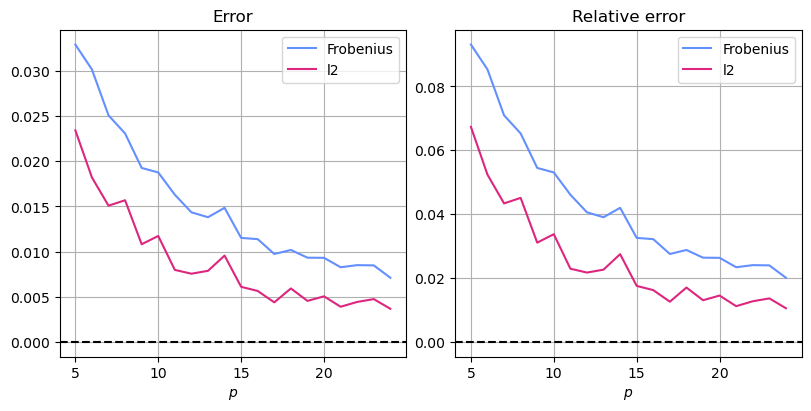

In [108]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

ax1.plot(p_range, errors['Frobenius'], label='Frobenius', c=C.c2[0])
ax1.plot(p_range, errors['l2'], label='l2', c=C.c2[1])
ax1.axhline(0.0, c='black', ls='--')

ax1.set_xlabel("$p$")
ax1.set_title("Error")

ax2.plot(p_range, errors['Frobenius rel'], label='Frobenius', c=C.c2[0])
ax2.plot(p_range, errors['l2 rel'], label='l2', c=C.c2[1])
ax2.axhline(0.0, c='black', ls='--')

ax2.set_xlabel("$p$")
ax2.set_title("Relative error")

ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.show()

In [109]:
W = get_discrete_W(V)
_, W1 = get_approximate_K_and_W(V, 10)

---
## 4. Inverse problem
### 4.1. Forward figure

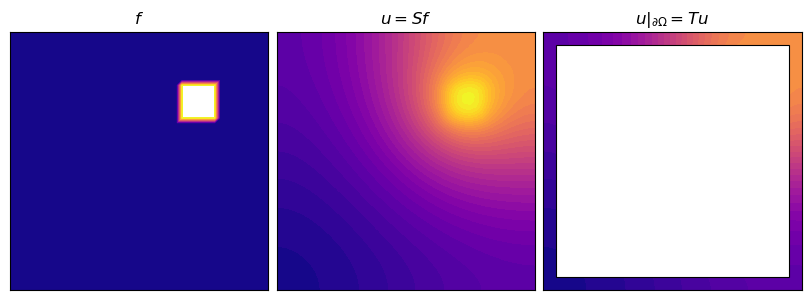

In [ ]:
def plot_K_mapping(V: FunctionSpace, f: Function, fig_name: Optional[str] = None):
    import matplotlib.patches as patches

    # ~~~~~ Mapping f -> u -> y ~~~~~
    x = f.vector().get_local()
    u = apply_S(V, x)

    # ~~~~~ Plot ~~~~~
    fig, axes = plt.subplots(1, 3, figsize=(8, 6), constrained_layout=True)
    axes = axes.flatten()

    shrink = 0.7
    cmap = "plasma"
    funcs = [f, u, u]
    names = ["$f$", "$u = Sf$", "$u|_{\partial\Omega} = Tu$"]

    for i, (ax, func, name) in enumerate(zip(axes, funcs, names)):
        plt.sca(ax)
        p0 = plot(func, title=name, cmap=cmap)
        #fig.colorbar(p0, ax=ax, format="%.3f", shrink=shrink)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 2:  # third subplot
            rect = patches.Rectangle(
                (0.05, 0.05), 0.9, 0.9, # (x0, y0), width, height
                linewidth=0.8,
                edgecolor="black",
                facecolor="white",
                zorder=10
            )
            ax.add_patch(rect)
    
    if fig_name is not None:
        plt.savefig(FIG_PATH + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


def get_square_f(V, x0=0.5, y0=0.5, w=0.15, h=0.15):
    x1 = x0 + w
    y1 = y0 + h
    code = f'x[0] >= {x0} && x[0] <= {x1} && x[1] >= {y0} && x[1] <= {y1} ? 1.0 : 0.0'
    f_expr = Expression(code, degree=1)
    f = Function(V)
    f.interpolate(f_expr)
    return f


def fig_S_and_T_example():
    n = 48
    V = FunctionSpace(UnitSquareMesh(n, n), 'CG', 1)
    f = get_square_f(V, 0.65, 0.65)

    plot_K_mapping(V, f, fig_name='S_and_T_example.png')


fig_S_and_T_example()

---
### Tikhonov regularization

Using the rSVD approximation
$$
K \approx \tilde K = U \Sigma V^T
$$
I solve the following problem
$$
\min_{f \in L^2(\Omega)}
\left\{
    \| \tilde K f - y \|^2
    + \lambda^2 \| W f \|^2
\right\}
$$

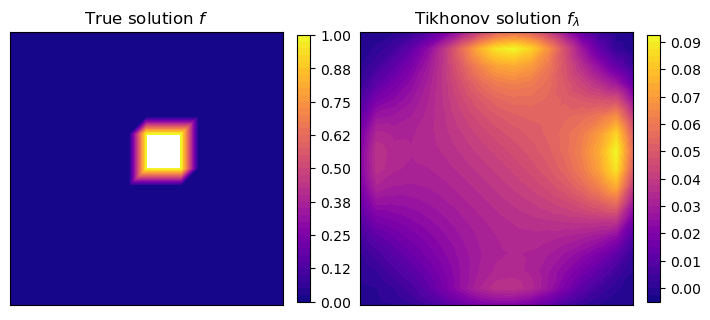

In [91]:
def tikhonov(A, b, lambda_):
    """Tikhonov regularization for a linear system Ax = b."""
    N = A.shape[1]
    T = (A.T @ A + lambda_ ** 2 * np.eye(N, N))
    z = A.T @ b
    x_lambda = np.linalg.solve(T, z)
    return x_lambda


def generalized_CV_tikhonov(A, b, lambdas):
    def get_phi_i(sigma_i, lam):
        return sigma_i ** 2 / (sigma_i ** 2 + lam ** 2)

    def G(x_lambda, m, sum_phi):
        num = np.linalg.norm(A @ x_lambda - b) ** 2
        denom = (m - sum_phi) ** 2
        return num / denom
    
    m = A.shape[0]
    _, S, _ = np.linalg.svd(A)
    Gs = np.zeros(lambdas.shape[0])
    for i, lam in enumerate(lambdas):
        x_lambda = tikhonov(A, b, lam)
        sum_phi = np.sum([get_phi_i(si, lam) for si in S])
        Gs[i] = G(x_lambda, m, sum_phi)

    return Gs


# Function space
n = 16
mesh = UnitSquareMesh(n, n)
V = FunctionSpace(mesh, 'CG', 1)
boundary_dofs = get_boundary_dofs(V)

# Mapping y = Kf
K = get_discrete_K(V)
f = get_square_f(V)
x = f.vector().get_local()
y = apply_K(V, x, boundary_dofs)

# Tikhonov regularization with GCV
lambdas = np.logspace(-3, 3, 100)
Gl = generalized_CV_tikhonov(K, y, lambdas)
lambda_best = lambdas[np.argmin(Gl)]

# Solve with optimal lambda
x_hat = tikhonov(K, y, lambda_=lambda_best)
f_hat = Function(V)
f_hat.vector()[:] = x_hat

fig, axes = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
axes = axes.flatten()

funcs = [f, f_hat]
names = ["True solution $f$", "Tikhonov solution $f_\lambda$"]
for ax, func, name in zip(axes, funcs, names):
    plt.sca(ax)
    p = plot(func, title=name, cmap='plasma')
    fig.colorbar(p, ax=ax, format="%.2f", shrink=0.68)
    ax.set_xticks([])
    ax.set_yticks([])

For the problem
$$
\min_{f \in L^2(\Omega)}
\left\{
    \| K f - y \|^2
    + \lambda^2 \| W f \|^2
\right\}
$$
Let $z = W f$, then $f = W^{-1} z$, so
$$
\| K f - y \|^2 + \lambda^2 \| W f \|^2 = 
\| (K W^{-1}) z + \lambda^2 \| z \|^2
$$
The new problem is therefore
$$
\min_{z \in L^2(\Omega)}
\left\{
    \| P z - y \|^2
    + \lambda^2 \| z \|^2
\right\}
$$
where $z = W f$ and $P W= K$


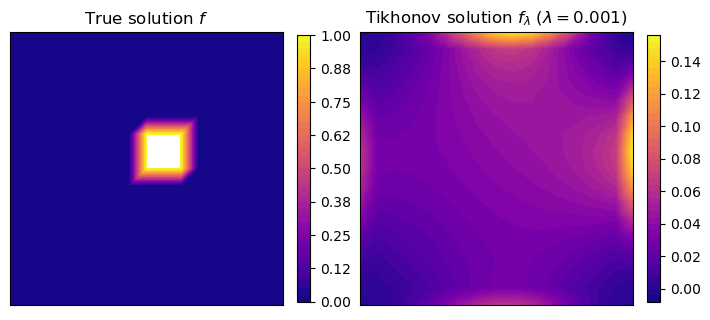

In [ ]:


#f_true_expr = exp(-100*((x-0.3)**2 + (y-0.3)**2)) + 0.5*exp(-80*((x-0.7)**2 + (y-0.7)**2))
#f_true = project(f_true_expr, Vf)

# Generalized Tikhonov
K = get_discrete_K(V)
W = get_discrete_W(V)
P = np.linalg.solve(W.T, K.T).T

# Tikhonov regularization with GCV
lambdas = np.logspace(-3, 3, 100)
Gl = generalized_CV_tikhonov(P, y, lambdas)
lambda_best = lambdas[np.argmin(Gl)]

# Solve with optimal lambda
z = tikhonov(P, y, lambda_=lambda_best)
x_hat = np.linalg.solve(W, z)
f_hat = Function(V)
f_hat.vector()[:] = x_hat

fig, axes = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
axes = axes.flatten()

funcs = [f, f_hat]
names = ["True solution $f$", f"Tikhonov solution $f_\lambda$ ($\lambda={lambda_best:.3f}$)"]
for ax, func, name in zip(axes, funcs, names):
    plt.sca(ax)
    p = plot(func, title=name, cmap='plasma')
    fig.colorbar(p, ax=ax, format="%.2f", shrink=0.68)
    ax.set_xticks([])
    ax.set_yticks([])